# Reactome pathway for each PSSM

In [2]:
from katlas.pssm import *
from katlas.score import *
from katlas.data import *
from katlas.plot import *
from katlas.pathway import *

import pandas as pd,seaborn as sns
from matplotlib import pyplot as plt

## Data processing

In [2]:
df = Data.get_human_site()

In [3]:
df.site_seq.duplicated().sum()

np.int64(2219)

In [4]:
df['sub_gene'] = df.substrate_genes.str.split(' ').str[0]

In [5]:
# check duplicates
df.site_seq.duplicated().sum()

np.int64(2219)

We want to avoid that because it will give duplicated scores

In [6]:
df2 = df.groupby('site_seq').agg(
    {'sub_site': lambda x: set(x.dropna()),
     'sub_gene': lambda x: set(x.dropna()),
     }).reset_index()

In [2]:
df2.site_seq.str[20].value_counts()

In [ ]:
df2['acceptor'] = df2.site_seq.str[20].str.upper()

In [ ]:
df2.head()

In [ ]:
df2.shape

## Scoring

In [11]:
out = predict_kinase_df(df2,seq_col='site_seq',**Params('PSPA'))

input dataframe has a length 117736
Preprocessing
Finish preprocessing
Merging reference
Finish merging


100%|██████████| 396/396 [00:43<00:00,  9.17it/s]


In [12]:
result_df = pd.concat([df2,out],axis=1)

In [17]:
df=result_df.copy()

In [ ]:
del out,result_df

In [75]:
# df.to_parquet('raw/pspa_score_df.parquet')

## Decide ratio

- Step1: Locate the max phosphoacceptor in the STY ratio of a kinase
- Step2: Get top 2% sites for that phosphoacceptor, and get the number of sites.
- Step3: Use the number and STY ratio to calculate the number of sites for other phosphoacceptor.

In [ ]:
pspa=Data.get_pspa_all_scale() 
# both two have ['0pS','0pT','0pY'] columns as STY ratio

In [7]:
def get_sty_ratio(series):
    """Return normalized S/T/Y ratio for a given kinase based on ref table."""
    s, t, y = series
    if y >= 0.8:  # tyrosine kinase
        return pd.Series({'S': 0, 'T': 0, 'Y': 1})

    elif 0.1 < y < 0.8:  # mixed S/T/Y kinase, only occur in CDDM.
        total = s + t + y
        return pd.Series({'S': s / total, 'T': t / total, 'Y': y / total})
    else:  # ser/thr kinase
        total = s + t
        return pd.Series({'S': s / total if total else 0, 'T': t / total if total else 0, 'Y': 0})

In [27]:
pspa_sty = pspa[['0pS','0pT','0pY']].apply(get_sty_ratio,axis=1)


In [28]:
pspa_sty['acceptors'] = pspa_sty.apply(lambda x: x[x!=0].index.tolist(),axis=1)

In [29]:
pspa_sty['max_acceptor'] = pspa_sty.iloc[:,:3].idxmax(axis=1)

In [8]:
def get_sty_thr_count(series,df,kinase):
    max_acceptor = series.max_acceptor
    scores = df[df.acceptor==max_acceptor][kinase]
    max_thr = scores.quantile(0.98)
    sty_dict={f'{max_acceptor}_thr':max_thr}

    count = int(scores[lambda x: x>=max_thr].count())
    sty_dict[f'{max_acceptor}_cnt'] = count

    for acceptor in series.acceptors:
        if acceptor != max_acceptor:
            acceptor_count = int((count/series[max_acceptor])*series[acceptor])
            sty_dict[f'{acceptor}_cnt'] = acceptor_count
            thr = df[df.acceptor==acceptor][kinase].nlargest(acceptor_count).min()
            sty_dict[f'{acceptor}_thr'] = thr
            
    return pd.Series(sty_dict)

In [ ]:
pspa_info = pspa_sty.apply(lambda x: get_sty_thr_count(x,df, x.name),axis=1)

In [38]:
pspa_info=pspa_info.fillna(0)

In [39]:
cnt_cols = ['S_cnt','T_cnt','Y_cnt']

In [40]:
pspa_info[cnt_cols] = pspa_info[cnt_cols].astype(int)

In [9]:
def get_genes(series,df,kinase):
    series = series[cnt_cols].astype(int)
    keys = series.index.str.split('_').str[0]
    vals = series.values
    site_dict={}
    for acceptor, cnt in zip(keys, vals):
        if cnt!=0:
            df_k = df[df.acceptor==acceptor].nlargest(cnt,columns=kinase)
            genes = set().union(*df_k.sub_gene)
            sites = set().union(*df_k.sub_site)
            site_dict[f'{acceptor}_genes'] = genes
            site_dict[f'{acceptor}_sites'] = sites
        else:
            site_dict[f'{acceptor}_genes'] = set()
            site_dict[f'{acceptor}_sites'] = set()
    return pd.Series(site_dict)

In [44]:
pspa_genes = pspa_info.apply(lambda x: get_genes(x,df,x.name),axis=1)

In [45]:
thr_cols = ['S_thr','T_thr','Y_thr']
gene_cols = ['S_genes','T_genes','Y_genes']

In [46]:
pspa_genes['genes']=pspa_genes[gene_cols].apply(lambda x: set().union(*x),axis=1)

In [47]:
pspa_info =pd.concat([pspa_info,pspa_genes],axis=1)

In [45]:
pspa_info.to_parquet('raw/pspa_path_info.parquet')

## repeat the same for cddm

Scoring first:

In [3]:
df = Data.get_human_site()
df['sub_gene'] = df.substrate_genes.str.split(' ').str[0]
df2 = df.groupby('site_seq').agg(
    {'sub_site': lambda x: set(x.dropna()),
     'sub_gene': lambda x: set(x.dropna()),
     }).reset_index()
df2['acceptor'] = df2.site_seq.str[20].str.upper()
del df
out = predict_kinase_df(df2,seq_col='site_seq',**Params('CDDM'))
result_df = pd.concat([df2,out],axis=1)
df=result_df.copy()
del out,result_df

Input dataframe has 117736 rows
Preprocessing...
Preprocessing done. Expanding sequences...
Merging reference...
Merge complete.


In [16]:
df.to_parquet('raw/cddm_score_df.parquet')

In [4]:
def plot_hist(df,
              kinase,
              sty_thr=None, # dict of thresholds per acceptor
              hue='acceptor'):
    
    "Plot histogram of a column (kinase). "
    
    plt.figure(figsize=(6,2))

    hist_params = {'element':'poly',
              'edgecolor': None,
              'alpha':0.5,
              'bins':100,
              'kde':True,
              'palette':sty_color}
    
    sns.histplot(data=df,x=kinase,hue=hue,**hist_params)
    
    plt.xlabel('')
    plt.title(f'{kinase} score distribution')

    if sty_thr:
        for acceptor,thr in sty_thr.items():
            if thr is not None:
                plt.axvline(thr,color=sty_color[acceptor])

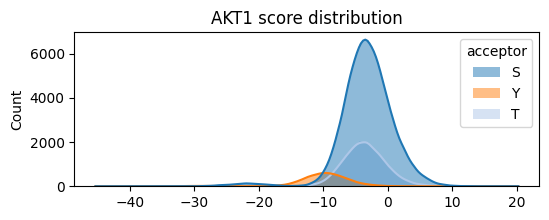

In [5]:
plot_hist(df,'AKT1')

Get the path info:

In [12]:
cnt_cols = ['S_cnt','T_cnt','Y_cnt']
thr_cols = ['S_thr','T_thr','Y_thr']
gene_cols = ['S_genes','T_genes','Y_genes']

In [13]:
cddm=Data.get_cddm()
cddm_sty = cddm[['0pS','0pT','0pY']].apply(get_sty_ratio,axis=1)
cddm_sty['acceptors'] = cddm_sty.apply(lambda x: x[x!=0].index.tolist(),axis=1)
cddm_sty['max_acceptor'] = cddm_sty.iloc[:,:3].idxmax(axis=1)
cddm_info = cddm_sty.apply(lambda x: get_sty_thr_count(x,df, x.name),axis=1)
cddm_info=cddm_info.fillna(0)
cddm_info[cnt_cols] = cddm_info[cnt_cols].astype(int)
cddm_genes = cddm_info.apply(lambda x: get_genes(x,df,x.name),axis=1)
cddm_genes['genes']=cddm_genes[gene_cols].apply(lambda x: set().union(*x),axis=1)
cddm_info =pd.concat([cddm_info,cddm_genes],axis=1)
cddm_info.to_parquet('raw/cddm_path_info.parquet')